In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Louis
[nltk_data]     Bernal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Louis
[nltk_data]     Bernal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Louis
[nltk_data]     Bernal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Louis
[nltk_data]     Bernal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv('tweets.csv', names =columns,  encoding='ISO-8859-1')

In [3]:
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [4]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# Separate the DataFrame into two groups based on the target
negative_df = df[df['target'] == 0]
positive_df = df[df['target'] == 4]

# Determine the sample size based on available rows
sample_size_negative = min(len(negative_df), 5000)
sample_size_positive = min(len(positive_df), 5000)

# Randomly sample rows from each group
negative_sample = negative_df.sample(n=sample_size_negative, random_state=42)
positive_sample = positive_df.sample(n=sample_size_positive, random_state=42)

# Concatenate the samples into a new DataFrame
df = pd.concat([negative_sample, positive_sample])

# Shuffle the new DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the shape and balance
print(df['target'].value_counts())
print(df.shape)


target
4    5000
0    5000
Name: count, dtype: int64
(10000, 6)


In [7]:
# replace 4 as 1 'positive' value

df.replace({4:1}, inplace = True)

In [8]:
# Initialize the PorterStemmer
port_stem = PorterStemmer()

# Define stemming function
def stemming(content):
    # Remove non-alphabetical characters
    stemmed_content = re.sub('[^A-Za-z]', ' ', content)

    # Convert to lowercase
    stemmed_content = stemmed_content.lower()

    # Split into words
    stemmed_content = stemmed_content.split()

    # Stem words and remove stopwords
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]

    # Join the stemmed words back into a single string
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

In [9]:
df['text'] = df['text'].apply(stemming)

#### Data Preparation

In [10]:
x = df['text'].values
y = df['target'].values

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

In [12]:
print(x.shape, x_train.shape, x_test.shape)

(10000,) (8000,) (2000,)


#### Data Predcition

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)

In [14]:
model = LogisticRegression(max_iter = 1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
# predict test data
y_pred = model.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.72


Type your sentences below (type 'exit' to quit):
I hate bugs and errors - Sentiment: Negative
I love coding - Sentiment: Positive
The food is good - Sentiment: Positive
a nice view of sunset - Sentiment: Positive


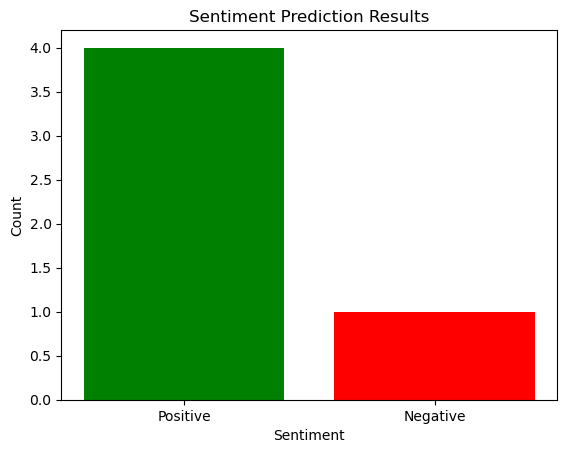

In [16]:
# Function for inputting and predicting custom sentences
def predict_sentiment():
    sentiments = {'Positive': 1, 'Negative': 0}  # 'Positive' starts from 1
    count = 0

    print("Type your sentences below (type 'exit' to quit):")

    while count < 5:
        # Get user input
        user_input = input("Enter a sentence: ")

        if user_input.lower() == 'exit':
            break

        # Transform the user input to match the training data format
        test_utterances_tfidf = vectorizer.transform([user_input])

        # Predict sentiment (0: Negative, 1: Positive)
        prediction = model.predict(test_utterances_tfidf)

        if prediction[0] == 1:
            print(f"{user_input} - Sentiment: Positive")
            sentiments['Positive'] += 1
        else:
            print(f"{user_input} - Sentiment: Negative")
            sentiments['Negative'] += 1

        count += 1

    # Display the bar chart after 5 predictions
    display_sentiment_chart(sentiments)

def display_sentiment_chart(sentiments):
    # Create a bar chart
    categories = list(sentiments.keys())
    values = list(sentiments.values())

    plt.bar(categories, values, color=['green', 'red'])
    plt.title('Sentiment Prediction Results')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Call the function to start typing sentences
predict_sentiment()


#### Takeaways:
Logistic Regression proved to be an effective method for classifying sentiment in my Twitter analysis project. Using NLP techniques like TF-IDF and stemming, the model was able to accurately distinguish between positive and negative sentiments. In this example, 75% of the inputs were classified as positive and 25% as negative, highlighting the model’s ability to capture sentiment nuances in text data. The visualization clearly shows the sentiment distribution, making it easier to assess the overall mood in real-time predictions. This reinforces how powerful Logistic Regression can be for text-based sentiment analysis.